This file reports the false discovery rate (FDR), and optionally the false negative rate (FNR) and false positive rate (FPR) of No Finding after loading in appropriate model outputs.

Specifically, it can be used to generate the following figures and tables by changing the variables in the first cell:
- **Table S7**: set metric = "FDR" and vary folder in ["MIMIC-CSV", "CXP-CSV", "NIH-CSV", "ALL-CSV"] by rerunning the notebook, copying the dataframe outputs in each run.
- **Figure 2**: set folder = "MIMIC-CSV" and vary metric in ["FPR", "FNR"]. Load relevant output images in the "figures" folder.
- **Figure S1**: set folder = "ALL-CSV" and vary metric in ["FPR", "FNR"]. Load relevant output images in the "figures" folder.
- **Figure S2**: set folder = "CXP-CSV" and vary metric in ["FPR", "FNR"]. Load relevant output images in the "figures" folder.
- **Figure S3**: set folder = "NIH-CSV" and vary metric in ["FPR", "FNR"]. Load relevant output images in the "figures" folder.




In [1]:
from pathlib import Path
import numpy as np
import pandas as pd 
import pickle
import json
import torch
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
from netcal.metrics import ECE
from scipy.stats import logistic
import scipy.stats as st
import warnings
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import wilcoxon, ranksums

def capscase(string):
    return string[0].upper() + string[1:].lower()

from tqdm import tqdm

from sklearn.metrics import recall_score, matthews_corrcoef, roc_auc_score, f1_score, accuracy_score, roc_curve, confusion_matrix, precision_score, precision_recall_curve, classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split


# OPTIONS
root_dir = Path('/scratch/ssd001/home/haoran/projects/CXR_Bias/')
folder = 'MIMIC-CSV'
metric = 'FDR' # ['FDR', 'FPR', 'FNR']
label_axis = False

ds_name = folder.split('-')[0]
out_dir = Path('figures')/ ds_name
out_dir.mkdir(exist_ok = True, parents = True)

meta = pd.read_csv(root_dir/folder/'True_withMeta.csv')
if folder.startswith('CXP'):
    meta = meta.rename(columns = {'Path': 'path'})
if folder.startswith('ALL'):
    meta = meta.rename(columns = {'Jointpath': 'path'})
    
    
def binary_metrics(targets, preds):    
    if len(targets) == 0:
        return {}
    res = {'accuracy': accuracy_score(targets, preds)}
    CM = confusion_matrix(targets, preds, labels = [0, 1])

    res['n_samples'] = len(targets)

    res['TN'] = CM[0][0].item()
    res['FN'] = CM[1][0].item()
    res['TP'] = CM[1][1].item()
    res['FP'] = CM[0][1].item()

    res['error'] = res['FN'] + res['FP']

    if res['TP']+res['FN'] == 0:
        res['TPR'] = 0
        res['FNR'] = 1
    else:
        res['TPR'] = res['TP']/(res['TP']+res['FN'])
        res['FNR'] = res['FN']/(res['TP']+res['FN'])

    if res['FP']+res['TN'] == 0:
        res['FPR'] = 1
        res['TNR'] = 0
    else:
        res['FPR'] = res['FP']/(res['FP']+res['TN'])
        res['TNR'] = res['TN']/(res['FP']+res['TN'])

    res['precision'] = res['TP'] / (res['TP'] + res['FP']) if (res['TP'] + res['FP']) > 0 else 0
    res['pred_prevalence'] = (res['TP'] + res['FP'])/res['n_samples']    
    res['prevalence'] = (res['TP'] + res['FN'])/res['n_samples']  
    
    return res

In [2]:
dfs = []
thresholds = []
for result in (root_dir/folder).glob('*/'):
    if result.is_dir() and not result.name.startswith('.'):
        df = pd.read_csv(result/'preds.csv')
        try:
            thresholds.append(pd.read_csv(result/'Threshold.csv').set_index('label').loc['No Finding']['bestthr'])
        except KeyError:
            continue
        if folder.startswith('CXP'):
            df = df.rename(columns = {'Path': 'path'})
        elif folder.startswith('ALL'):
            df = df.rename(columns = {'Jointpath': 'path'})
        df = df.merge(meta, on = 'path', how = 'inner')
        if 'race' in df.columns:
            df.loc[df.race == '0', 'race'] = 'UNKNOWN'
            df.loc[df.insurance == '0', 'insurance'] = 'UNKNOWN'
        if folder.startswith('MIMIC'):
            df = df.rename(columns = {
                'age_decile': 'Age',
                'gender': 'Sex'
            })
            df['race'] = df['race'].map({
                'WHITE': 'WHITE',
                'UNKNOWN': 'UNKNOWN',
                'OTHER': 'OTHER',
                'HISPANIC/LATINO': 'HISPANIC',
                'BLACK/AFRICAN AMERICAN': 'BLACK',
                'ASIAN': 'ASIAN',
                'AMERICAN INDIAN/ALASKA NATIVE': 'NATIVE'                
            })
        
        dfs.append(df)

In [3]:
grps = {
    'Sex': {
        'M': 'Male',
        'F': 'Female'
    },
    'Age': {
        x: x for x in [ '80-', '60-80', '40-60', '20-40', '0-20']
    },
    'race': {
        x: x for x in [ 'WHITE', 'NATIVE', 'OTHER', 'ASIAN', 'HISPANIC','BLACK']
    },
    'insurance': {
        'Medicare': 'MEDICARE',
        'Other': 'OTHER',
        'Medicaid': 'MEDICAID'
    }
}

colors = {
    'Sex': 'pink',
    'Age': 'green',
    'race': 'brown',
    'insurance': 'orange'
}

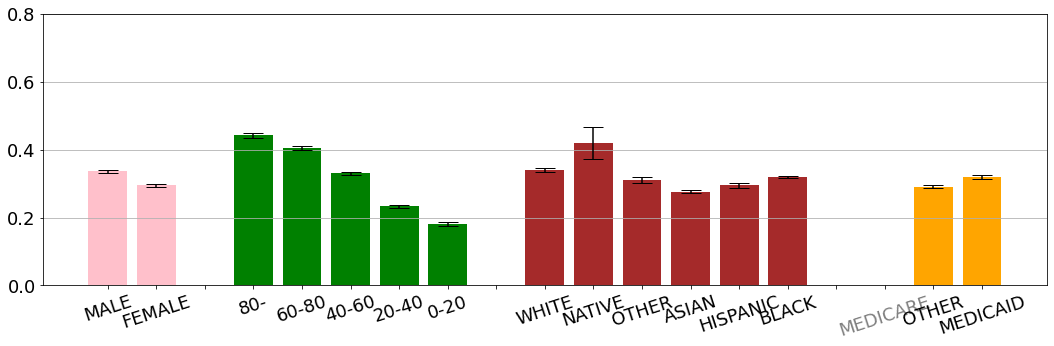

In [4]:
# main plot
fig, ax = plt.subplots(figsize=(18 if folder.startswith('MIMIC') else 9,5))
fontsize = 18

counter = 0
all_fdrs = []
for attr in grps:
    if attr in dfs[0].columns:
        pos = np.arange(counter, counter + len(grps[attr]))
        fdrs = []
        for grp in grps[attr]:
            fdr_g = []
            for c, df in enumerate(dfs):
                sub = df.query(f'{attr} == "{grp}"')
                if metric == 'FDR':
                    fdr_g.append(1 - precision_score(sub['No Finding'], sub['prob_No Finding'] >= thresholds[c]))
                elif metric == 'FPR':
                    fdr_g.append(binary_metrics(sub['No Finding'], sub['prob_No Finding'] >= thresholds[c])['FPR'])
                elif metric == 'FNR':
                    fdr_g.append(binary_metrics(sub['No Finding'], sub['prob_No Finding'] >= thresholds[c])['FNR'])
                else:
                    raise NotImplementedError
            
            if grp == 'Medicare':
                fdrs.append((np.NAN, np.NAN))
            else:
                fdrs.append((
                    np.mean(fdr_g),
                    1.96 * np.std(fdr_g) / np.sqrt(5),
                    # np.mean(precisions_g) + 1.96 * np.std(precisions_g) / np.sqrt(5),
                ))
            all_fdrs.append({
                'grp': grp,
                metric: "{0:.1%}".format(fdrs[-1][0]) + ' ± ' + "{0:.1%}".format(fdrs[-1][1]) if not pd.isnull(fdrs[-1][-1]) else ''
            })
        fdrs = np.array(fdrs)
        ax.bar(pos, fdrs[:, 0], yerr=fdrs[:, 1].T, align='center', alpha=1, ecolor='black', capsize=10, color=colors[attr])
        
        counter += len(grps[attr]) + 1

if folder.startswith('MIMIC'):        
    labels = ['MALE', 'FEMALE',"",'80-', '60-80', '40-60', '20-40', '0-20',"",'WHITE', 'NATIVE', 'OTHER', 'ASIAN', 'HISPANIC','BLACK','', 'MEDICARE', 'OTHER', 'MEDICAID']
    my_colors = ['k', 'k','', 'k', 'k','k','k','k', 
      '', 'k', 'k','k','k','k','k','', 'grey','k','k']
else:
    labels = ['MALE', 'FEMALE',"",'80-', '60-80', '40-60', '20-40', '0-20']
    my_colors = ['k', 'k','', 'k', 'k','k','k','k']

x_pos = np.arange(len(labels))
if label_axis:
    ax.set_ylabel(metric,fontsize = fontsize)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels,fontsize = fontsize, rotation=18)
ax.tick_params(axis = 'y', labelsize = fontsize)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)    
    
# ax.set_ylim(top = min(1.0, np.ceil(ax.get_ylim()[1]*10)/10))
ax.set_ylim(top = 0.8)
ax.yaxis.grid(True)
plt.savefig(out_dir/f'{metric}_main.eps', bbox_inches = 'tight', dpi = 300)

In [5]:
pd.DataFrame(all_fdrs)

,grp,FDR
0,M,33.6% ± 0.5%
1,F,29.4% ± 0.4%
2,80-,44.2% ± 0.8%
3,60-80,40.4% ± 0.5%
4,40-60,33.0% ± 0.4%
5,20-40,23.3% ± 0.4%
6,0-20,18.1% ± 0.6%
7,WHITE,34.0% ± 0.6%
8,NATIVE,42.0% ± 4.7%
9,OTHER,31.0% ± 0.8%


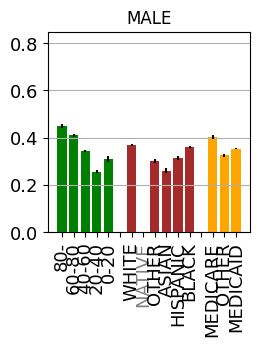

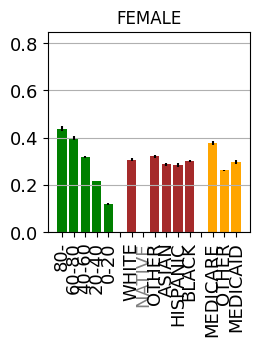

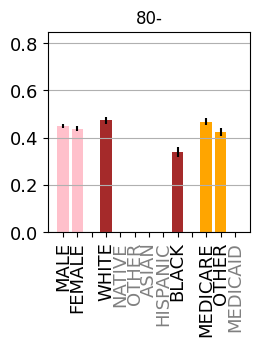

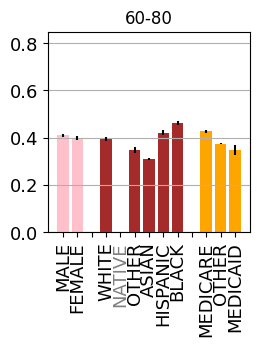

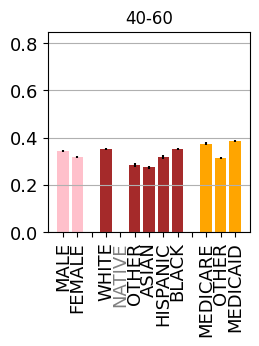

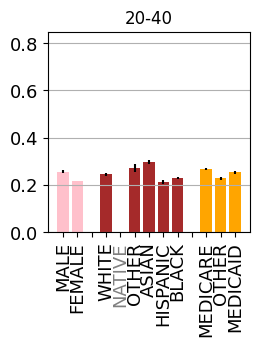

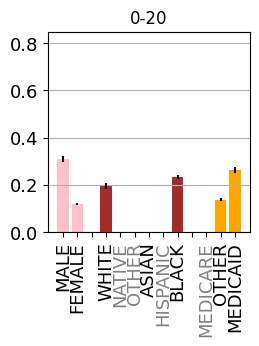

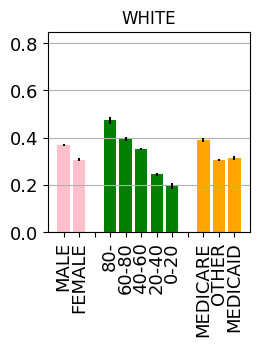

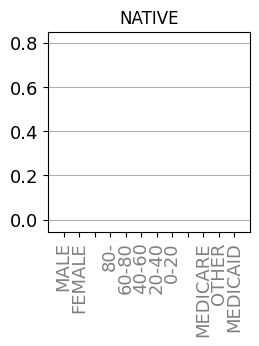

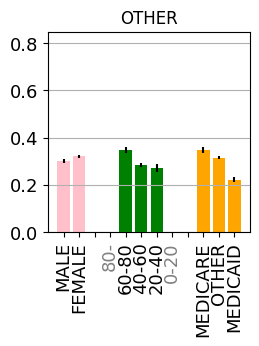

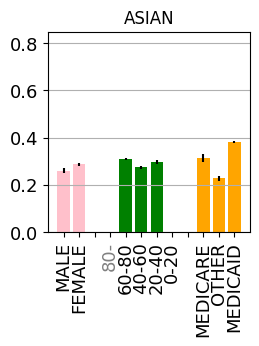

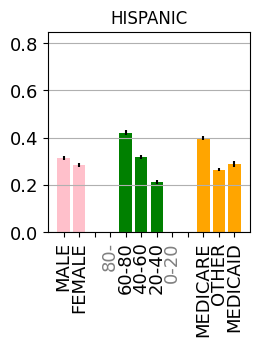

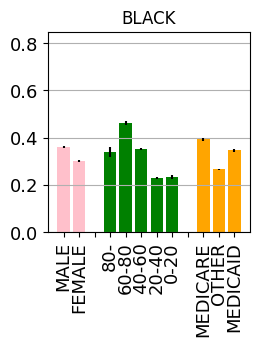

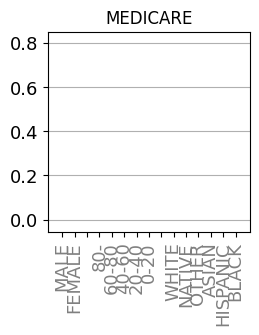

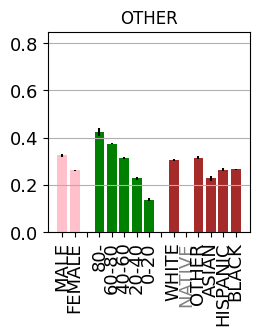

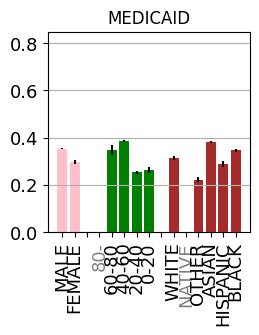

In [7]:
# intersectional plots
fontsize = 13
plt.rcdefaults()
for attr in grps:
    if attr in dfs[0].columns:
        for grp in grps[attr]:
            subs = [df.query(f'{attr} == "{grp}"') for df in dfs]   
            counter = 0
            labels, my_colors = [], []
            fig, ax = plt.subplots(figsize=(2.6,2.6))
            
            for attr2 in grps:
                if attr2 in dfs[0].columns and attr2 != attr:                    
                    pos = np.arange(counter, counter + len(grps[attr2]))
                    fdrs = []
                    for grp2 in grps[attr2]:
                        fdr_g = []
                        for c, sub in enumerate(subs):
                            sub2 = sub.query(f'{attr2} == "{grp2}"')
                            if len(sub2) == 0:
                                fdr_g.append(0)
                            else:
                                if metric == 'FDR':
                                    fdr_g.append(1 - precision_score(sub2['No Finding'], sub2['prob_No Finding'] >= thresholds[c],
                                                                    zero_division = 0))
                                elif metric == 'FPR':
                                    fdr_g.append(binary_metrics(sub2['No Finding'], sub2['prob_No Finding'] >= thresholds[c])['FPR'])
                                elif metric == 'FNR':
                                    fdr_g.append(binary_metrics(sub2['No Finding'], sub2['prob_No Finding'] >= thresholds[c])['FNR'])
                                else:
                                    raise NotImplementedError

                        if grp == 'Medicare' or len(sub2) <= 15 or sub2['No Finding'].sum() <= 15:
                           #  fdrs.append((np.NAN, np.NAN))
                            fdrs.append((0, 0))
                            my_colors.append('grey')
                        else:
                            fdrs.append((
                                np.mean(fdr_g),
                                1.96 * np.std(fdr_g) / np.sqrt(5),
                                # np.mean(precisions_g) + 1.96 * np.std(precisions_g) / np.sqrt(5),
                            ))
                            my_colors.append('k')
                        labels.append(grps[attr2][grp2])
                    fdrs = np.array(fdrs)
                    ax.bar(pos, fdrs[:, 0], yerr=fdrs[:, 1].T, align='center', color=colors[attr2])
        
                    counter += len(grps[attr2]) + 1
                    my_colors.append('')
                    labels.append('')
            ax.set_title(grps[attr][grp].upper())
            # ax.set_ylim(top = min(1.0, np.ceil(ax.get_ylim()[1]*10)/10))
            ax.set_ylim(top = 0.85)
            ax.yaxis.grid(True)
            x_pos = np.arange(len(labels) - 1)
            ax.set_xticks(x_pos)
            ax.tick_params(axis = 'y', labelsize = fontsize)
            for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors[:-1]):
                ticklabel.set_color(tickcolor)
            ax.set_xticklabels([i.upper() for i in labels[:-1]], fontsize = fontsize,rotation=90)
            plt.savefig(out_dir/f'{metric}_inter_{grp}.eps', bbox_inches = 'tight', dpi = 300)